In [12]:
from datasets import load_dataset
from transformers import pipeline
import transformers as trf

import re  #preprocessing
import pandas as pd  #data handling
from time import time  #time-to-run
from collections import defaultdict  #word frequency

import spacy  #preprocessing/tokenization

import logging  #gensim logging
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

from tqdm import tqdm

import matplotlib.pyplot as plt

from sklearn.feature_extraction import text as sktext
from nltk.stem.porter import PorterStemmer

import scipy as sp
import numpy as np

tf-idf, BoW, Word2Vec, Doc2Vec для feature extraction

In [3]:
# 0. Dataset overview

# https://huggingface.co/docs/datasets/v2.10.0/en/package_reference/main_classes#datasets.Dataset
# Based on an Apache Arrow

SPLITS = ['train', 'test', 'validation']
FEATURES = ['article', 'highlights']

dataset = load_dataset("cnn_dailymail", "3.0.0", split='train')

WARNING - 14:10:05: Found cached dataset cnn_dailymail (C:/Users/mkrooted/.cache/huggingface/datasets/cnn_dailymail/3.0.0/3.0.0/1b3c71476f6d152c31c1730e83ccb08bcf23e348233f4fcc11e182248e6bf7de)


In [4]:
dataset = dataset.shard(num_shards=10, index=0)
dataset = dataset.remove_columns("id").to_pandas()

pd.set_option('display.max_colwidth', 200)
dataset['article'].head()

0    LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune as he turns 18 on Monday, but he insists the money won't cast a spell...
1    WASHINGTON (CNN) -- As he awaits a crucial progress report on Iraq, President Bush will try to put a twist on comparisons of the war to Vietnam by invoking the historical lessons of that conflict ...
2    LAS VEGAS, Nevada (CNN)  -- Former football star O.J. Simpson will be held without bail after his arrest on robbery and assault charges, police announced late Sunday. Police released this mug shot...
3    LONDON, England (CNN) -- Prince Harry led tributes to Diana, Princess of Wales on the 10th anniversary of her death, describing her as "the best mother in the world" in a speech at a memorial serv...
4    ABECHE, Chad (CNN) -- Most of the 103 children that a French charity attempted to take to France from Chad for adoption are neither Sudanese nor orphans, three international a

In [5]:
dataset['highlights'].head()

0    Harry Potter star Daniel Radcliffe gets £20M fortune as he turns 18 Monday .\nYoung actor says he has no plans to fritter his cash away .\nRadcliffe's earnings from first five Potter films have be...
1    President Bush to address the Veterans of Foreign Wars on Wednesday .\nBush to say that withdrawing from Vietnam emboldened today's terrorists .\nSpeech will be latest White House attempt to try t...
2    No bail for ex-NFL star accused of directing men in alleged armed robbery .\nSimpson faces charges of robbery, assault, burglary and conspiracy .\nAlleged robbery involved sports-related items, po...
3    Prince Harry describes Princess Diana as "the best mother in the world"\nHe asks for her to be remembered as "fun-loving, generous, down-to-earth, entirely genuine"\nBishop of London praises her h...
4    NEW: Chadian president wants journalists, flight crew released .\nRed Cross, UNICEF, UNHCR interview children that charity tried to fly out of Chad .\nMost are not from Sudan 

In [6]:
dataset.shape

(28712, 2)

In [7]:
# check if it needs cleaning
dataset.isnull().sum()

article       0
highlights    0
dtype: int64

(count    28712.000000
 mean      4028.154674
 std       1952.018407
 min        186.000000
 25%       2567.000000
 50%       3667.000000
 75%       5134.000000
 max      11613.000000
 Name: article, dtype: float64,
 count    28712.000000
 mean       295.540471
 std        122.041696
 min         42.000000
 25%        218.000000
 50%        281.000000
 75%        343.000000
 max       3971.000000
 Name: highlights, dtype: float64)

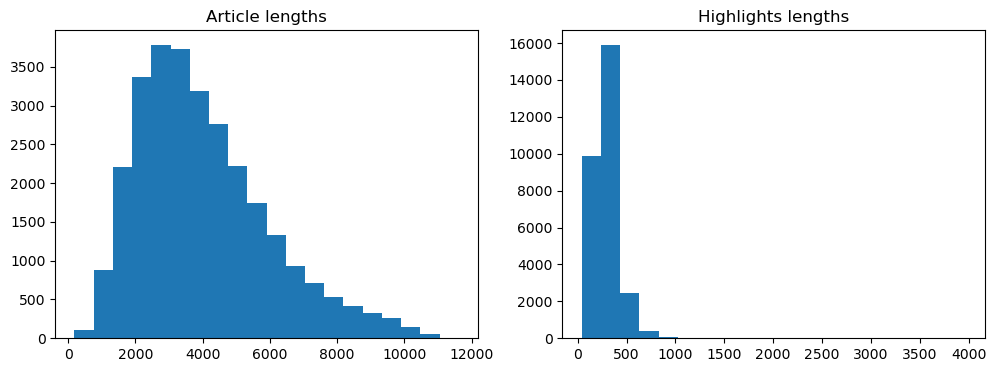

In [8]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.set_title("Article lengths"), ax1.hist(dataset['article'].str.len(), 20)
ax2.set_title("Highlights lengths"), ax2.hist(dataset['highlights'].str.len(), 20)
fig.set_size_inches(12,4)
dataset['article'].str.len().describe(), dataset['highlights'].str.len().describe()

In [9]:
# 1. Preprocessing.
# - remove all not alphabetical symbols (leave apostrophe as it is used in "don't", "isn't", "he'd")
# - make all leters lowercase
# - apply the Spacy pipeline
# - remove stop-tokens

def clean_tokens(doc):
    txt = [token.lemma_ for token in doc if not token.is_stop]
    if len(txt) > 2:
        return txt

def filter_symbols(ds):
    for f in FEATURES:
        #  ds[f] is a pandas Series
        ds[f] = ds[f].str.lower().str.replace(re.compile("[^a-z']+"), ' ', regex=True)
    return ds

## Токенізація та очистка
Видалення чисел та спец.символів. Розбиття фраз на токени по символу пробіла. Стеммінг (зведення слів до кореня слова).

In [11]:
%%time

stemmer = PorterStemmer() 

# remove symbols
dataset = filter_symbols(dataset)

# perform stemming
dataset['article'] = dataset['article'].apply(lambda x: [stemmer.stem(i) for i in x.split()]) # stemming
dataset['highlights'] = dataset['highlights'].apply(lambda x: [stemmer.stem(i) for i in x.split()]) # stemming

CPU times: total: 6min 6s
Wall time: 6min 17s


In [5]:
# dataset.to_pickle('dataset.pkl')
dataset = pd.read_pickle('dataset.pkl')

In [6]:
dataset['article'].head()

0    [london, england, reuter, harri, potter, star,...
1    [washington, cnn, as, he, await, a, crucial, p...
2    [la, vega, nevada, cnn, former, footbal, star,...
3    [london, england, cnn, princ, harri, led, trib...
4    [abech, chad, cnn, most, of, the, children, th...
Name: article, dtype: object

## Feature extraction та ембедінг
Різні моделі, що надають словам числове представлення.

1. Перша частина - надання кожному слову (чи послідовності символів, біграму, підслову) деякого значення (токену).  
    Це в деякому сенсі пошук найбільш ефективного стиснення вхідного корпусу тексту.  

2. Друга частина - ембедінг цих токенів в n-вимірний лінійний простір.  
    Відносне розташування токенів в цьому просторі покаже зв'язок між ними.

### 1. BOW

Обидві BOW та TF-IDF ембедять текст розбиваючи його на символах та вайтспейсі (тобто, одне слово - один токен, без розбиття на підслова чи n-грами). 

- BoW для Bag of words.  
    У цій моделі фраза представляється вектором частот слів. В словник потрапляють всі бачені раніше слова.  
    Для збільшення точності моделі можна також зберігати контекст слів. Тобто, словник складатиметься не лише зі слів, а й з пар, трійок, n-грамів слів. 
- TF-IDF для term frequency–inverse document frequency  
    Ця модель наслідує BoW, але значення кожного токену фрази домножується на фактор важливості для цього корпуса фраз (1/частота).  
    Таким чином слова, що дуже поширені в корпусі, будуть менше впливати на представлення окремих фраз. 

In [7]:
corpus = dataset.applymap(lambda x: " ".join(x))
corpus.head()

,article,highlights
0,london england reuter harri potter star daniel...,harri potter star daniel radcliff get m fortun...
1,washington cnn as he await a crucial progress ...,presid bush to address the veteran of foreign ...
2,la vega nevada cnn former footbal star o j sim...,no bail for ex nfl star accus of direct men in...
3,london england cnn princ harri led tribut to d...,princ harri describ princess diana as the best...
4,abech chad cnn most of the children that a fre...,new chadian presid want journalist flight crew...


In [8]:
import sklearn as sk
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [9]:
%%time

# max_df - найбільша дозволена частота
# min_df- найменша дозволеня частота
# ngram_range - згенерувати словник та виконати навчання на н-граммах заданої довжини 
bow_vectorizer1 = CountVectorizer(ngram_range=(1,1), max_df=1.0, min_df=2, max_features=2000, stop_words='english')
bow_vectorizer1 = bow_vectorizer1.fit(corpus['highlights'])
bow_vectorizer1 = bow_vectorizer1.fit(corpus['article'])

CPU times: total: 29 s
Wall time: 34.7 s


In [10]:
%%time

bow_vectorizer2 = CountVectorizer(ngram_range=(1,2), max_df=1.0, min_df=2, max_features=5000, stop_words='english')
bow_vectorizer2 = bow_vectorizer2.fit(corpus['highlights'])
bow_vectorizer2 = bow_vectorizer2.fit(corpus['article'])

CPU times: total: 2min 12s
Wall time: 2min 34s


In [17]:
bow_vectorizer2.get_feature_names_out()

array(['aaron', 'abandon', 'abbey', ..., 'zimmerman', 'zone', 'zoo'],
      dtype=object)

В словнику дійсно є біграми

In [13]:
bow2_features =  bow_vectorizer2.get_feature_names_out();
tmp = np.array([len(x.split())>1 for x in bow2_features])
bow2_features[tmp][:30]

array(['abc news', 'accept comment', 'accord new', 'accord polic',
       'accord report', 'ad wa', 'african american', 'agenc said',
       'ago wa', 'air forc', 'al assad', 'al qaeda', 'ani time',
       'answer question', 'appear court', 'april updat', 'arm forc',
       'arsen wenger', 'ask wa', 'associ press', 'aston villa',
       'attack wa', 'attorney gener', 'august updat', 'author said',
       'author say', 'barack obama', 'bayern munich', 'becaus hi',
       'becaus wa'], dtype=object)

In [14]:
df_bow1 = pd.DataFrame(bow_vectorizer1.transform(corpus['article']).toarray(), columns=bow_vectorizer1.get_feature_names_out())
df_bow1.head()

,abandon,abil,abl,abov,absolut,abus,academi,accept,access,accid,...,year,yesterday,york,yorkshir,young,younger,youth,youtub,zealand,zone
0,0,0,2,0,0,0,0,0,1,0,...,2,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0
3,0,0,1,1,0,0,0,0,0,0,...,4,0,1,0,2,0,0,0,0,0
4,0,0,2,0,0,0,0,0,0,0,...,2,0,0,0,1,0,1,0,0,1


In [15]:
df_bow2 = pd.DataFrame(bow_vectorizer2.transform(corpus['article']).toarray(), columns=bow_vectorizer2.get_feature_names_out())
df_bow2.head()

,aaron,abandon,abbey,abbott,abc,abc news,abduct,abil,abl,aboard,...,younger,youngest,youngster,youth,youtub,zealand,zero,zimmerman,zone,zoo
0,0,0,0,0,0,0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,2,0,...,0,0,0,1,0,0,0,0,1,0


## 2. TF-IDF

In [16]:
%%time

tfidf_vectorizer1 = TfidfVectorizer(ngram_range=(1,1), max_df=0.90, min_df=2, max_features=2000, stop_words='english')
tfidf_vectorizer1 = tfidf_vectorizer1.fit(corpus['highlights'])
tfidf_vectorizer1 = tfidf_vectorizer1.fit(corpus['article'])

CPU times: total: 27.4 s
Wall time: 36.4 s


In [17]:
%%time 

tfidf_vectorizer2 = TfidfVectorizer(ngram_range=(1,2), max_df=0.90, min_df=2, max_features=5000, stop_words='english')
tfidf_vectorizer2 = tfidf_vectorizer2.fit(corpus['highlights'])
tfidf_vectorizer2 = tfidf_vectorizer2.fit(corpus['article'])

CPU times: total: 1min 55s
Wall time: 2min 2s


In [18]:
df_tfidf1 = pd.DataFrame(tfidf_vectorizer1.transform(corpus['article']).toarray(), columns=tfidf_vectorizer1.get_feature_names_out())
df_tfidf1.head()

,abandon,abil,abl,abov,absolut,abus,academi,accept,access,accid,...,year,yesterday,york,yorkshir,young,younger,youth,youtub,zealand,zone
0,0.0,0.0,0.096621,0.000000,0.0,0.0,0.0,0.0,0.063124,0.0,...,0.043523,0.0,0.000000,0.0,0.047261,0.0,0.000000,0.0,0.0,0.000000
1,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000
2,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.030609,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000
3,0.0,0.0,0.021189,0.025996,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.038179,0.0,0.023711,0.0,0.041459,0.0,0.000000,0.0,0.0,0.000000
4,0.0,0.0,0.049519,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.022306,0.0,0.000000,0.0,0.024222,0.0,0.039216,0.0,0.0,0.041133


In [19]:
df_tfidf2 = pd.DataFrame(tfidf_vectorizer2.transform(corpus['article']).toarray(), columns=tfidf_vectorizer2.get_feature_names_out())
df_tfidf2.head()

,aaron,abandon,abbey,abbott,abc,abc news,abduct,abil,abl,aboard,...,younger,youngest,youngster,youth,youtub,zealand,zero,zimmerman,zone,zoo
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.085867,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.018799,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.045398,0.0,...,0.0,0.0,0.0,0.035953,0.0,0.0,0.0,0.0,0.037709,0.0


In [20]:
from joblib import dump, load

In [21]:
%%time

dump(bow_vectorizer1, 'bow1.jbl')
dump(bow_vectorizer2, 'bow2.jbl')
dump(tfidf_vectorizer1, 'tfidf1.jbl')
dump(tfidf_vectorizer2, 'tfidf2.jbl')

CPU times: total: 1min 4s
Wall time: 1min 7s


['tfidf2.model']

## 2. Word2Vec

In [20]:
import gensim
from gensim.models import Word2Vec

спочатку створення словника 

In [27]:
%%time

tokenized_txt = np.concatenate([dataset['article'], dataset['highlights']])

CPU times: total: 31.2 ms
Wall time: 19 ms


In [27]:
model_w2v = gensim.models.Word2Vec(
            tokenized_txt,
            vector_size=1000, # desired no. of features/independent variables
            window=3, # context window size
            min_count=2, # Ignores all words with total frequency lower than 2.                                  
            sg = 1, # 1 for skip-gram model
            hs = 0, # ієрархічна сигмоіда
            negative = 10, # for negative sampling
            workers= 7, # no.of cores
            seed = 34
) 

INFO - 23:27:24: collecting all words and their counts
INFO - 23:27:24: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 23:27:25: PROGRESS: at sentence #10000, processed 6576145 words, keeping 74625 word types
INFO - 23:27:27: PROGRESS: at sentence #20000, processed 13368577 words, keeping 116914 word types
INFO - 23:27:28: PROGRESS: at sentence #30000, processed 19529568 words, keeping 145100 word types
INFO - 23:27:28: PROGRESS: at sentence #40000, processed 19944034 words, keeping 145653 word types
INFO - 23:27:28: PROGRESS: at sentence #50000, processed 20443279 words, keeping 146658 word types
INFO - 23:27:29: collected 147454 word types from a corpus of 20848462 raw words and 57424 sentences
INFO - 23:27:29: Creating a fresh vocabulary
INFO - 23:27:29: Word2Vec lifecycle event {'msg': 'effective_min_count=2 retains 92252 unique words (62.56% of original 147454, drops 55202)', 'datetime': '2023-04-02T23:27:29.552706', 'gensim': '4.3.0', 'python': '3.8.15 |

навчання

In [29]:
model_w2v.save("w2v.beforetrain.model")

INFO - 00:05:10: Word2Vec lifecycle event {'fname_or_handle': 'w2v.beforetrain.model', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2023-04-03T00:05:10.496980', 'gensim': '4.3.0', 'python': '3.8.15 | packaged by conda-forge | (default, Nov 22 2022, 08:42:03) [MSC v.1929 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'saving'}
INFO - 00:05:10: storing np array 'vectors' to w2v.beforetrain.model.wv.vectors.npy
INFO - 00:05:10: storing np array 'syn1neg' to w2v.beforetrain.model.syn1neg.npy
INFO - 00:05:11: not storing attribute cum_table
INFO - 00:05:11: saved w2v.beforetrain.model


In [46]:
%%time

model_w2v.train(tokenized_txt, total_examples=len(tokenized_txt), epochs=2)

WARNING - 00:40:50: Effective 'alpha' higher than previous training cycles
INFO - 00:40:50: Word2Vec lifecycle event {'msg': 'training model with 7 workers on 92252 vocabulary and 1000 features, using sg=1 hs=0 sample=0.001 negative=10 window=3 shrink_windows=True', 'datetime': '2023-04-03T00:40:50.463799', 'gensim': '4.3.0', 'python': '3.8.15 | packaged by conda-forge | (default, Nov 22 2022, 08:42:03) [MSC v.1929 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
INFO - 00:40:51: EPOCH 0 - PROGRESS: at 0.03% examples, 5993 words/s, in_qsize 14, out_qsize 0
INFO - 00:40:53: EPOCH 0 - PROGRESS: at 0.21% examples, 22184 words/s, in_qsize 14, out_qsize 0
INFO - 00:40:54: EPOCH 0 - PROGRESS: at 0.39% examples, 27909 words/s, in_qsize 14, out_qsize 0
INFO - 00:40:55: EPOCH 0 - PROGRESS: at 0.51% examples, 25728 words/s, in_qsize 14, out_qsize 0
INFO - 00:40:57: EPOCH 0 - PROGRESS: at 0.69% examples, 27832 words/s, in_qsize 13, out_qsize 0
INFO - 00:40:58: EPOCH 0 

CPU times: total: 1h 6min 46s
Wall time: 15min


(32902753, 41696924)

In [21]:
%%time

# model_w2v.save("word2vec2.model")
model_w2v = Word2Vec.load('word2vec2.model')

INFO - 14:32:33: loading Word2Vec object from word2vec2.model
INFO - 14:32:33: loading wv recursively from word2vec2.model.wv.* with mmap=None
INFO - 14:32:33: loading vectors from word2vec2.model.wv.vectors.npy with mmap=None
INFO - 14:32:33: loading syn1neg from word2vec2.model.syn1neg.npy with mmap=None
INFO - 14:32:34: setting ignored attribute cum_table to None
INFO - 14:32:35: Word2Vec lifecycle event {'fname': 'word2vec2.model', 'datetime': '2023-04-04T14:32:35.123923', 'gensim': '4.3.0', 'python': '3.8.15 | packaged by conda-forge | (default, Nov 22 2022, 08:42:03) [MSC v.1929 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'loaded'}


CPU times: total: 1.45 s
Wall time: 2.01 s


In [22]:
print(model_w2v.wv['cnn'][:30])
print(model_w2v.wv['cnn'].shape)

[ 0.25530708  0.0418107  -0.1916443   0.13079019 -0.07019693  0.47680637
 -0.4486242  -0.08844084  0.23242836  0.21449769  0.0774828  -0.09907719
 -0.17487927 -0.09859507  0.30308524 -0.07530126  0.21837196  0.5746339
  0.11556537  0.17687523 -0.07149184  0.1228452   0.177354    0.05355405
 -0.00938293  0.19263054 -0.08252652 -0.031635    0.08062591 -0.0893074 ]
(1000,)


In [23]:
model_w2v.wv.most_similar(positive=['trump'], topn=10)

[("extant'", 0.3557014763355255),
 ("trump'", 0.3430766761302948),
 ('donald', 0.33647969365119934),
 ('ivanka', 0.33301395177841187),
 ('fortin', 0.3094308078289032),
 ('boria', 0.30866342782974243),
 ("holders'", 0.3077753484249115),
 ('tisher', 0.30365774035453796),
 ('lvh', 0.302690327167511),
 ("clippers'", 0.2998731732368469)]

In [24]:
model_w2v.wv.most_similar(positive=['govt'], topn=10)

[('governmnt', 0.7205761671066284),
 ("innocence'", 0.7195187211036682),
 ('bayik', 0.7125713229179382),
 ('tsima', 0.7069346308708191),
 ("'remain'", 0.7040842175483704),
 ("cooperate'", 0.7006606459617615),
 ('ilna', 0.6998783349990845),
 ("'permissible'", 0.6982656717300415),
 ('ssbn', 0.6980330348014832),
 ('coag', 0.6977931261062622)]

In [25]:
model_w2v.wv.most_similar(positive=['donald', 'trump', 'woman'], negative=['man'], topn=10)

[('fortin', 0.3646680414676666),
 ('ivanka', 0.3631719946861267),
 ('rumsfeld', 0.3616224229335785),
 ('tisher', 0.3574274480342865),
 ("rumsfeld'", 0.35679250955581665),
 ("extant'", 0.3442106246948242),
 ("benard'", 0.34179022908210754),
 ('ramotar', 0.339875191450119),
 ('verrilli', 0.33555150032043457),
 ('baverstock', 0.33410245180130005)]

## Doc2Vec


In [28]:
%%time
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

tagged_data = [TaggedDocument(words=tokenized_txt[i], tags=[i]) for i, text in tqdm(enumerate(tokenized_txt), total=len(tokenized_txt))]


100%|██████████| 57424/57424 [00:01<00:00, 45247.03it/s]

CPU times: total: 1.25 s
Wall time: 1.27 s


In [29]:
tagged_data[:5]

[TaggedDocument(words=['london', 'england', 'reuter', 'harri', 'potter', 'star', 'daniel', 'radcliff', 'gain', 'access', 'to', 'a', 'report', 'million', 'million', 'fortun', 'as', 'he', 'turn', 'on', 'monday', 'but', 'he', 'insist', 'the', 'money', "won't", 'cast', 'a', 'spell', 'on', 'him', 'daniel', 'radcliff', 'as', 'harri', 'potter', 'in', 'harri', 'potter', 'and', 'the', 'order', 'of', 'the', 'phoenix', 'to', 'the', 'disappoint', 'of', 'gossip', 'columnist', 'around', 'the', 'world', 'the', 'young', 'actor', 'say', 'he', 'ha', 'no', 'plan', 'to', 'fritter', 'hi', 'cash', 'away', 'on', 'fast', 'car', 'drink', 'and', 'celebr', 'parti', 'i', "don't", 'plan', 'to', 'be', 'one', 'of', 'those', 'peopl', 'who', 'as', 'soon', 'as', 'they', 'turn', 'suddenli', 'buy', 'themselv', 'a', 'massiv', 'sport', 'car', 'collect', 'or', 'someth', 'similar', 'he', 'told', 'an', 'australian', 'interview', 'earlier', 'thi', 'month', 'i', "don't", 'think', "i'll", 'be', 'particularli', 'extravag', 'the',

In [30]:
%%time

doc2vec_model = Doc2Vec(vector_size=500, window=5, min_count=1, workers=7, epochs=5)
doc2vec_model.build_vocab(tagged_data)


INFO - 14:37:59: Doc2Vec lifecycle event {'params': 'Doc2Vec<dm/m,d500,n5,w5,s0.001,t7>', 'datetime': '2023-04-04T14:37:59.660911', 'gensim': '4.3.0', 'python': '3.8.15 | packaged by conda-forge | (default, Nov 22 2022, 08:42:03) [MSC v.1929 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'created'}
INFO - 14:37:59: collecting all words and their counts
INFO - 14:37:59: PROGRESS: at example #0, processed 0 words (0 words/s), 0 word types, 0 tags
INFO - 14:38:01: PROGRESS: at example #10000, processed 6576145 words (3968398 words/s), 74625 word types, 0 tags
INFO - 14:38:02: PROGRESS: at example #20000, processed 13368577 words (4422191 words/s), 116914 word types, 0 tags
INFO - 14:38:04: PROGRESS: at example #30000, processed 19529568 words (4269605 words/s), 145100 word types, 0 tags
INFO - 14:38:04: PROGRESS: at example #40000, processed 19944034 words (3483867 words/s), 145653 word types, 0 tags
INFO - 14:38:04: PROGRESS: at example #50000, processed 20443279 wor

CPU times: total: 8.53 s
Wall time: 8.56 s


In [31]:
%%time

doc2vec_model.train(tagged_data, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs)


INFO - 14:38:13: Doc2Vec lifecycle event {'msg': 'training model with 7 workers on 147454 vocabulary and 500 features, using sg=0 hs=0 sample=0.001 negative=5 window=5 shrink_windows=True', 'datetime': '2023-04-04T14:38:13.208171', 'gensim': '4.3.0', 'python': '3.8.15 | packaged by conda-forge | (default, Nov 22 2022, 08:42:03) [MSC v.1929 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'train'}
INFO - 14:38:14: EPOCH 0 - PROGRESS: at 1.41% examples, 376163 words/s, in_qsize 13, out_qsize 0
INFO - 14:38:15: EPOCH 0 - PROGRESS: at 3.13% examples, 412290 words/s, in_qsize 13, out_qsize 0
INFO - 14:38:16: EPOCH 0 - PROGRESS: at 4.68% examples, 403721 words/s, in_qsize 13, out_qsize 0
INFO - 14:38:17: EPOCH 0 - PROGRESS: at 6.33% examples, 416014 words/s, in_qsize 13, out_qsize 0
INFO - 14:38:18: EPOCH 0 - PROGRESS: at 8.04% examples, 436154 words/s, in_qsize 13, out_qsize 0
INFO - 14:38:19: EPOCH 0 - PROGRESS: at 9.80% examples, 452027 words/s, in_qsize 13, out_qsize 0

CPU times: total: 14min 22s
Wall time: 3min 55s


In [32]:
%%time

doc2vec_model.save('doc2vec.model')

INFO - 15:41:23: Doc2Vec lifecycle event {'fname_or_handle': 'doc2vec.model', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2023-04-04T15:41:23.333119', 'gensim': '4.3.0', 'python': '3.8.15 | packaged by conda-forge | (default, Nov 22 2022, 08:42:03) [MSC v.1929 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'saving'}
INFO - 15:41:23: storing np array 'vectors' to doc2vec.model.dv.vectors.npy
INFO - 15:41:23: storing np array 'vectors' to doc2vec.model.wv.vectors.npy
INFO - 15:41:24: storing np array 'syn1neg' to doc2vec.model.syn1neg.npy
INFO - 15:41:25: not storing attribute cum_table
INFO - 15:41:29: saved doc2vec.model


CPU times: total: 4.44 s
Wall time: 6.41 s


In [33]:

train_doc2vec = [doc2vec_model.dv[i] for i in range(len(tagged_data))]

df_doc2vec = pd.DataFrame(train_doc2vec, columns=[f'd2v_{i}' for i in range(len(train_doc2vec[0]))])
print(df_doc2vec.shape)

(57424, 500)


In [35]:
df_doc2vec.head(20)

,d2v_0,d2v_1,d2v_2,d2v_3,d2v_4,d2v_5,d2v_6,d2v_7,d2v_8,d2v_9,...,d2v_490,d2v_491,d2v_492,d2v_493,d2v_494,d2v_495,d2v_496,d2v_497,d2v_498,d2v_499
0,0.009146,0.135201,-0.072994,0.109454,0.032862,-0.084373,-0.115515,0.035941,0.056813,-0.007856,...,0.011083,-0.006971,0.129004,-0.052965,-0.039812,-0.102277,-0.046127,0.039498,-0.050144,-0.040776
1,-0.254942,0.163544,0.144764,-0.201737,0.021458,0.082663,-0.196433,0.291852,-0.050810,-0.143372,...,0.203257,-0.032465,0.072306,0.063957,0.375055,-0.272121,-0.088481,-0.091671,-0.232066,-0.159121
2,-0.117900,-0.205202,0.076487,0.248966,0.330469,-0.231428,0.300577,-0.185738,-0.008185,0.135714,...,-0.068809,-0.293921,-0.084564,-0.072338,-0.073040,0.206475,0.011905,-0.033004,-0.014633,0.127483
3,-0.371820,0.602867,-0.203390,-0.102770,-0.103232,0.407222,0.461428,-0.000071,-0.317226,0.319846,...,0.096749,-0.036819,0.167973,-0.165922,0.095167,-0.435485,0.189312,-0.273624,-0.537506,-0.132500
4,-0.090567,0.428923,0.165335,0.263781,-0.078844,-0.109712,-0.169765,0.304967,-0.522379,-0.027402,...,-0.085700,0.202710,-0.085429,0.201375,0.064493,-0.011604,0.063875,-0.015089,-0.189288,-0.117034
5,-0.005234,0.487663,-0.303303,0.379280,0.113641,-0.034873,-0.250474,0.172742,0.020811,-0.038632,...,-0.134437,0.307425,-0.052848,-0.141365,0.133257,0.067346,0.059676,-0.069288,-0.394645,-0.079529
6,0.043946,-0.125210,0.104873,0.013544,-0.314978,0.183172,-0.059742,0.108255,-0.133991,-0.475386,...,-0.175854,0.095062,-0.238719,0.150316,0.378035,-0.214385,-0.006071,0.127032,-0.397404,-0.048258
7,0.068000,0.023628,-0.001098,0.132458,-0.006013,-0.144483,0.071708,0.107586,-0.174358,-0.049099,...,0.000540,-0.182187,0.190492,-0.078451,0.188239,0.060563,0.099130,0.061242,-0.208240,-0.076943
8,0.085855,0.201693,0.013570,0.225817,-0.018103,-0.203849,0.157434,0.194524,0.235533,0.070185,...,0.018435,0.098082,-0.152709,-0.294708,0.245699,0.230518,0.272622,0.045745,-0.179743,-0.128255
9,-0.234718,0.214549,-0.107383,0.000633,-0.108019,-0.276795,-0.066781,-0.130171,-0.160185,0.178869,...,0.254332,-0.199368,0.062413,0.056273,0.333717,0.131662,0.329352,0.024872,-0.361907,-0.148662
